In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent.parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str
    iter: int

In [5]:
with open("../sklearn/svc.pkl", "rb") as f:
    pipe = pickle.load(f)

with open("../sklearn/svc_type0.pkl", "rb") as f:
    pipe0 = pickle.load(f)

with open("../sklearn/svc_type1.pkl", "rb") as f:
    pipe1 = pickle.load(f)

In [6]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    
    experiments = sorted(glob.glob(job.fn("no_shear_short_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", "_")
        temp = utils.extract_between(exper, "temp-", "/")
        iter = utils.extract_between(exper, "iter-", ".gsd")
        df_path = exper.replace("traj-fire", "softness").replace(".gsd", ".parquet")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep, iter=int(iter))
        print(sp)
        

        # if job.isfile(df_path):
        #     continue

        traj = gsd.hoomd.open(exper)

        all_pos = np.zeros((len(traj), traj[0].particles.N, 3), dtype=np.float32)
        for frame in range(len(traj)):
            snap = traj[frame]
            all_pos[frame] = snap.particles.position

        phop = schmeud_rs.dynamics.p_hop(all_pos, 11)

        softness = []
        frames = []
        types = []
        for frame in tqdm(range(len(phop))):

            frames.append(frame)

            snap = traj[frame]

            typeids = snap.particles.typeid
            types.append(typeids)
            softb = np.zeros_like(typeids, dtype=np.float32)

            query_indices0 = np.arange(snap.particles.N)[typeids == 0]
            sfs0 = ml.compute_structure_functions_snap(snap, query_indices0)
            soft0 = pipe0.decision_function(sfs0)

            query_indices1 = np.arange(snap.particles.N)[typeids == 1]
            sfs1 = ml.compute_structure_functions_snap(snap, query_indices1)
            soft1 = pipe1.decision_function(sfs1)

            softb[typeids == 0] = soft0
            softb[typeids == 1] = soft1

            softness.append(softb)

        dataset = pl.DataFrame({"frame": frames, "id": np.array(types), "soft": np.array(softness), "phop": phop})
        dataset.write_parquet(job.fn(df_path), use_pyarrow=True)

634e14bc75836df75158fb15f379d8bb
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=0)


100%|██████████| 189/189 [00:56<00:00,  3.35it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=2)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=3)


100%|██████████| 189/189 [00:56<00:00,  3.36it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.38it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=0)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.44it/s]


7ec2f6aca035e69077eab24383a21cb6
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=3)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


cfa1e4c0007fd65d020f809715a6f0b4
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


ecce68c50e28a33684826f28780bf6e9
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


1d0fe2ba44a6f635f5504dcbcee0ebc9
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=3)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


1083a2a09eec2c6cf215ebc7a9706cac
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.48it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.46it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


09d3dccc56f1fa9330b57901cd232ab7
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=0)


100%|██████████| 189/189 [00:57<00:00,  3.30it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=1)


100%|██████████| 189/189 [00:57<00:00,  3.31it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=0)


100%|██████████| 189/189 [00:56<00:00,  3.33it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.38it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=1)


100%|██████████| 189/189 [00:56<00:00,  3.36it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=2)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=3)


100%|██████████| 189/189 [00:56<00:00,  3.36it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.38it/s]


6976a7c10ada4159010403f8027f3ea5
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=3)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


9158e73b2e4c9fd1a565e1e5d1bc3af5
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=0)


100%|██████████| 189/189 [00:56<00:00,  3.34it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.38it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.47it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=2)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='HTL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='HTL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


c6d7afd0de62bfa16d05da47815227eb
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=2)


100%|██████████| 189/189 [00:56<00:00,  3.37it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=3)


100%|██████████| 189/189 [00:56<00:00,  3.35it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


bf92a185d043ce3ef666e05e427c7e76
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=2)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.38it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=3)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


a8f2c249ed85533b56b0729b7ab96d18
Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.14877, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.38it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.19836, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=0)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.3, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=1)


100%|██████████| 189/189 [00:55<00:00,  3.41it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.4, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.44it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.049591, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.43it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=0)


100%|██████████| 189/189 [00:55<00:00,  3.39it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=1)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=2)


100%|██████████| 189/189 [00:55<00:00,  3.42it/s]


Statepoint(max_shear=0.0, period=5000.0, temp=0.099182, prep='ESL', iter=3)


100%|██████████| 189/189 [00:55<00:00,  3.40it/s]


In [7]:
output = defaultdict(list)


for job in project:
    print(job)
    prep = job.sp["prep"]
    
    experiments = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", "_")
        temp = utils.extract_between(exper, "temp-", "/")
        iter = utils.extract_between(exper, "iter-", ".gsd")
        df_path = exper.replace("traj-fire", "softness").replace(".gsd", ".parquet")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep, iter=int(iter))
        

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
            output[sp].append(dataset)
            continue


634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


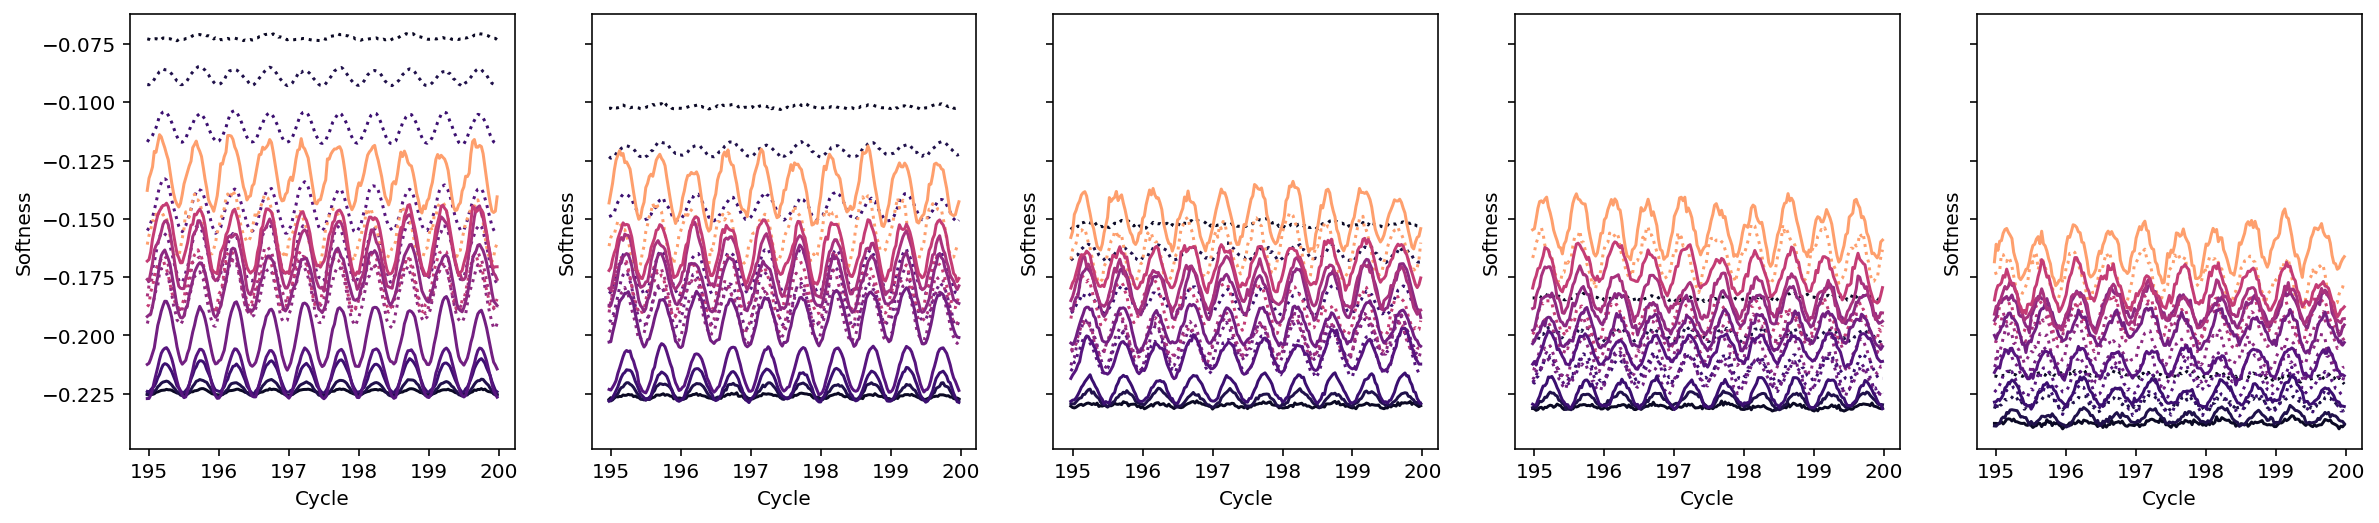

In [9]:
cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.15)

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for key, value in output.items():
    if key.prep == "HTL":
        ln = ":"
    else:
        ln = "-"
    
    dataset = pl.concat(value)
    xs = []
    ys = []

    temps = [0.019836, 0.049591, 0.099182, 0.14877, 0.19836]
    i = temps.index(key.temp)
    ax = axs[i]
    
    for frame, df in dataset.group_by("frame", maintain_order=True):
        # print(frame)
        df = df.explode(["id", "soft"])
        mean_soft = df["soft"].mean()

        xs.append(frame/40)
        ys.append(mean_soft)
    ax.plot(xs, ys, linestyle=ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")

for ax in axs:
    ax.set_xlabel("Cycle")
    ax.set_ylabel("Softness")